In [1]:
import numpy as np 
import pandas as pd 

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


In [2]:
CLEAN_TWEETS = False

# Importing library and checking GPU

In [3]:
import numpy as np
import pandas as pd
import os, re

import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

2024-02-26 00:09:58.886694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 00:09:58.886803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 00:09:59.010065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0


In [5]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
#!pip install transformers

Installing Hugging face lib, but look like they already interaged in 

In [6]:
df = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 24,783



,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
11261,11548,3,0,3,0,1,I'm fasho in that hoe then! RT @BJayBlast: TBR...
8850,9096,3,0,1,2,2,Dreamed I was eating a brownie and started sal...
20497,20943,3,0,3,0,1,Really ain't nuttin to cut that bitch off
6250,6430,3,0,3,0,1,@jeronimosolano don't be a pussy! Just talk to...
733,744,3,2,1,0,0,#JesusChrist was STRAIGHT&gt; That's why the #...
17830,18232,3,1,2,0,1,RT @Trap_Jesus: Never seen a nigga get laughed...
22153,22622,3,2,1,0,0,This time a night dark skin niggas really turn...
23609,24103,3,0,0,3,2,being up at 5am cuz your cat meowed at a noctu...
4428,4559,3,1,2,0,1,@PraviKingDino you like men faggot.
17992,18396,3,1,2,0,1,RT @VillageBae: Don't block me because you thi...


In the [class] collum: <br>
0 prefer to hate speech <br>
1 is offensive <br>
2 is neither

# Preprocessing

In [7]:
#strip tweet related character
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
#check functionality
print(df['tweet'][1])
strip_all_entities(df['tweet'][1])

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!


'RT boy dats cold tyga dwn bad for cuffin dat hoe in the 1st place'

In [8]:
if CLEAN_TWEETS == False:
    df['tweet']=df['tweet'].apply(strip_all_entities)

In [15]:
sentences = df['tweet'].values
labels = df['class'].values

# Train Test Val split

In [10]:
from sklearn.model_selection import train_test_split

train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)

In [25]:
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

In [31]:
# Get the lists of sentences and their labels.
trn_sentences = train['tweet'].values
train_labels = train['class'].values

tst_sentences = test['tweet'].values
test_labels = test['class'].values

val_sentences = validation['tweet'].values
validation_labels = validation['class'].values

## tokenization

In [16]:
from transformers import BertTokenizer

print('loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

loading Bert tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
enc_exp = tokenizer.encode('My name is Sukriti Narang')
dec_exp = tokenizer.decode(enc_exp)
print(enc_exp)
print(dec_exp)

[101, 2026, 2171, 2003, 24110, 102]
[CLS] my name is quan [SEP]


## padding & masking

In [18]:
print('Max array length: ', max([len(i) for i in sentences]))

Max array length:  581


In [19]:
count1, count2, count3 = 0, 0, 0
for i in sentences:
    if len(i)>100:
        count1+=1
    if len(i)>200:
        count2+=1
    if len(i)>300:
        count3+=1
print('number of array longer than 100: ', count1)
print('number of array longer than 200: ', count2)
print('number of array longer than 300: ', count3)

number of array longer than 100:  5713
number of array longer than 200:  23
number of array longer than 300:  7


In [20]:
# from statistics import mean 

# token_len = []
# for i in sentences:
#     if len(i)>100 and len(i)<200:
#         enc = tokenizer.encode(i)
#         token_len.append(len(enc))
# print('average token length: ', mean(token_len))
# print('maximum token length: ', max(token_len))

average token length:  31.558446124099138
maximum token length:  83


--output-- <br>
average token length:  31.558446124099138 <br>
maximum token length:  83

In [21]:
# count = 0
# for i in token_len:
#     if i > 64:
#         count+=1
# print('number of sentence longer than 64 words:', count)

number of sentence longer than 64 words: 14


--output-- <br>
number of sentence longer than 64 words: 14

In [22]:
def bert_encode(data, max_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length = max_len,
                                        padding = 'max_length',
                                        truncation = True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [27]:
print(len(sentences),len(trn_sentences),len(tst_sentences),len(val_sentences))

24783 19826 2478 2479


In [29]:
MAX_LEN = 64
train_inputs, train_masks = bert_encode(trn_sentences,MAX_LEN)

#test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

validation_inputs, validation_masks = bert_encode(val_sentences,MAX_LEN)

## convert data to pytorch datatype

In [32]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/tmp/ipykernel_34/1696369575.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
/tmp/ipykernel_34/1696369575.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)


In [33]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# BERT for sequence classification

In [34]:
from transformers import BertForSequenceClassification, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3, 
                    
    output_attentions = False, 
    output_hidden_states = False,
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## optimizer

In [35]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8) # args.adam_epsilon  - default is 1e-8.

In [36]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## training loop

In [37]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [38]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [39]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:08.
  Batch    80  of    620.    Elapsed: 0:00:16.
  Batch   120  of    620.    Elapsed: 0:00:23.
  Batch   160  of    620.    Elapsed: 0:00:31.
  Batch   200  of    620.    Elapsed: 0:00:39.
  Batch   240  of    620.    Elapsed: 0:00:46.
  Batch   280  of    620.    Elapsed: 0:00:54.
  Batch   320  of    620.    Elapsed: 0:01:01.
  Batch   360  of    620.    Elapsed: 0:01:09.
  Batch   400  of    620.    Elapsed: 0:01:17.
  Batch   440  of    620.    Elapsed: 0:01:24.
  Batch   480  of    620.    Elapsed: 0:01:32.
  Batch   520  of    620.    Elapsed: 0:01:39.
  Batch   560  of    620.    Elapsed: 0:01:47.
  Batch   600  of    620.    Elapsed: 0:01:54.

  Average training loss: 0.30
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:07.
  Batch    80  of    620.    Elap

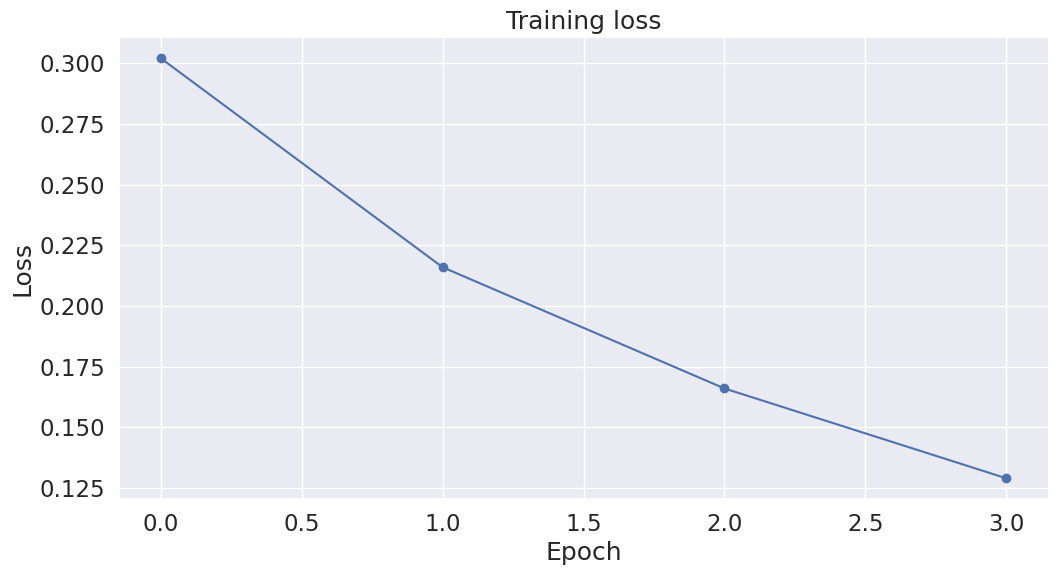

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# On test set

In [41]:
test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [42]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,478 test sentences...
    DONE.


## Matthew's correlation coefficient
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [43]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 3-column ndarray (one column for "0" 
  # one for "1" and one for "2"). Pick the label with the highest value and turn this
  # in to a list of 0s, 1s, 2s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [64]:
# Combine the predictions for each batch into a single list of 0s,1s, 2s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.753


## confusion matrix

In [68]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.48      0.41      0.45       155
           1       0.94      0.95      0.94      1893
           2       0.91      0.90      0.90       430

    accuracy                           0.91      2478
   macro avg       0.78      0.75      0.76      2478
weighted avg       0.90      0.91      0.91      2478

